In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, Audio
import librosa.feature as ft
import wave
import struct
import librosa
import time
import librosa.display
from os import listdir
from os.path import isfile, join
import scipy.io
from mpl_toolkits import mplot3d
import pickle
%matplotlib widget

In [2]:
def remove_init_noise(sig, fs, method="mean", ratio_parameter = 6, len_noise = 1000) :
    """
    Renvoie le signal tronqué avec le vecteurs temps associé

    # Inputs
    - sig : signal audio à tronquer
    - fs : fréquence d'échantillonnage (utile pour regénérer le vecteur temps)
    - ratio_parameter : paramètre à adapter pour couper plus ou moins le bruit. 6 par défaut

    # Ouputs
    - time : nouveau vecteur temps
    - sig : nouveau signal audio tronqué
    """
    sig /= np.max(np.abs(sig))
    noise = sig[:len_noise]
    if method == "mean" :
        noise_threshold = np.mean(np.abs(noise))
    elif method == "max" :
        noise_threshold = np.max(np.abs(noise))

    i=0
    while np.abs(sig[i]) < ratio_parameter*noise_threshold :
        i += 1
    #i correspond au premier indice au dessus du seuil
    sig = sig[i:]
    time = np.arange(len(sig))/fs
    return time, sig

In [3]:
def spectral_slope(data, sr, n_fft=2048, hop_length=None, win_length=None, 
                   window='hann', center=True, pad_mode='constant'):

    S, phase = librosa.magphase(librosa.stft(y=data, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window, 
                                             center=center, pad_mode=pad_mode))
    slope = np.zeros((1,S.shape[1]))
    freq = librosa.fft_frequencies(sr=sr, n_fft=n_fft)
    for k in range(S.shape[1]):
        fit = np.polyfit(freq, S[:,k], 1)
        slope[0,k] =fit[0]
    return slope


def compute_features(data, sr, S=None, n_fft=2048, frame_length=2048, hop_length=512, win_length=None, window='hann',
                     center=True, pad_mode='constant', freq=None, fmin=200.0, n_bands=6, quantile=0.02, linear=False, centroid=None, norm=True,
                     p=2, amin=1e-10, power=2.0,roll_percent=0.85):
    
    
    cent = librosa.feature.spectral_centroid(y=data, sr=sr, S=S, n_fft=n_fft, hop_length=hop_length, freq = freq,
                                             win_length=win_length, window=window, center=center, pad_mode=pad_mode)
    spec_bw = librosa.feature.spectral_bandwidth(y=data, sr=sr, S=S, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window, 
                                                 center=center, pad_mode=pad_mode, freq=freq, centroid=centroid, norm=norm, p=p)
    contrast = librosa.feature.spectral_contrast(y=data, sr=sr, S=S, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window, center=center,
                                                 pad_mode=pad_mode, freq=freq, fmin=fmin, n_bands=n_bands, quantile=quantile, linear=linear)
    
    flatness = librosa.feature.spectral_flatness(y=data, S=S, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window, center=center,
                                                 pad_mode=pad_mode, amin=amin, power=power)
    
    rolloff = librosa.feature.spectral_rolloff(y=data, sr=sr, S=S, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window, 
                                                center=center, pad_mode=pad_mode, freq=freq, roll_percent=roll_percent)
    zcr = librosa.feature.zero_crossing_rate(y=data, frame_length=frame_length, hop_length=hop_length, center=center)
    
    rms = librosa.feature.rms(y=data, S=S, frame_length=frame_length, hop_length=hop_length, center=center, pad_mode=pad_mode)
    
    slope = spectral_slope(data, sr, n_fft=n_fft, hop_length=hop_length, win_length=win_length, 
                   window=window, center=center, pad_mode=pad_mode)
    
    dict_features = {}
    dict_features['spectral_centroid'] = cent
    dict_features['spectral_bandwidth'] = spec_bw
    dict_features['spectral_contrast'] = contrast
    dict_features['spectral_flatness'] = flatness
    dict_features['spectral_rolloff'] = rolloff
    dict_features['zero_crossing_rate'] = zcr
    dict_features['rms'] = rms
    dict_features['spectral_slope'] = slope
    
    return dict_features

In [4]:
def recup_data(monRepertoire):
    fichiers = [f for f in listdir(monRepertoire) if (isfile(join(monRepertoire, f)) and 'parametres' not in f)]
    data={}
    k=0
    with open(monRepertoire+"parametres.pickle", "rb") as handle:
            parameters_dict = pickle.load(handle)
    for fichier in fichiers:
        
        data_seul,_ = librosa.load(monRepertoire+fichier,sr=Fe)
        data[list(parameters_dict.keys())[k]] = data_seul
        k+=1
    all_cle = list(data.keys())
                
    return all_cle,data


In [5]:
def ordoner_data(data,all_cle):
    M = np.zeros((len(data[all_cle[0]]), len(data.keys())))
    i=0
    for cle in all_cle:
        M[:,i] = data[cle]
        i+=1
    return M

In [6]:
def creer_features(data,all_cle,M):
    data_features={}
    for k in range(len(all_cle)):
        data_features[all_cle[k]] = compute_features(M[:,k], sr=Fe, S=None, n_fft=2048, hop_length=256, win_length=None, window='hann',
                         center=True, pad_mode='constant', freq=None, fmin=200.0, n_bands=6, quantile=0.02, linear=False, centroid=None, norm=True,
                         p=2, amin=1e-10, power=2.0,roll_percent=0.85)
    return data_features

In [39]:
def recup_features(repertoire_features):
    with open(repertoire_features+"audio_features_mean.pickle", "rb") as handle:
        dict_class = pickle.load(handle)
    return dict_class

In [7]:
features_already_calculate = True
repertoire_features = "../../Mesures/1ier_data_set/"


Fe = 2**15
repertoire_1 = '../../Mesures/1ier_data_set/acier/'
repertoire_2 = '../../Mesures/1ier_data_set/medium_1/'
repertoire_3 = '../../Mesures/1ier_data_set/medium_2/'
repertoire_4 = '../../Mesures/1ier_data_set/plexi/'

l = Fe*3/256 #256 c'est pour hop_length, 3 la durée en seconde
debut = int(l//4) #Séparation entre l'attaque et le reste
fin = -10

if features_already_calculate == False:
    liste_repertoire = [repertoire_1,repertoire_2,repertoire_3,repertoire_4]
    dict_class={}
    for repertoire in liste_repertoire:
        all_cle,data = recup_data(repertoire)
        M=ordoner_data(data,all_cle)
        data_features = creer_features(data,all_cle,M)

        M_spec_bw = np.zeros((len(data_features[all_cle[0]]['spectral_bandwidth'][0]),len(all_cle)))
        M_cent = np.zeros((len(data_features[all_cle[0]]['spectral_centroid'][0]),len(all_cle)))
        M_contrast = np.zeros((len(data_features[all_cle[0]]['spectral_contrast'][0]),len(all_cle)))
        M_flatness = np.zeros((len(data_features[all_cle[0]]['spectral_flatness'][0]),len(all_cle)))
        M_slope = np.zeros((len(data_features[all_cle[0]]['spectral_slope'][0]),len(all_cle)))
        M_rolloff= np.zeros((len(data_features[all_cle[0]]['spectral_rolloff'][0]),len(all_cle)))
        i=0
        for cle in all_cle:
            M_spec_bw[:,i] = data_features[cle]['spectral_bandwidth'][0]
            M_cent[:,i] = data_features[cle]['spectral_centroid'][0]
            M_contrast[:,i] = data_features[cle]['spectral_contrast'][0]
            M_flatness[:,i] = data_features[cle]['spectral_flatness'][0]
            M_slope[:,i] = data_features[cle]['spectral_slope'][0]
            M_rolloff[:,i] = data_features[cle]['spectral_rolloff'][0]
            i+=1


        M_spec_bw_mean = np.mean(M_spec_bw[debut:fin,:] /np.amax(np.abs(M_spec_bw[debut:fin,:]),axis=0), axis=0)
        M_cent_mean = np.mean(M_cent[debut:fin,:] /np.amax(np.abs(M_cent[debut:fin,:]),axis=0), axis=0)
        M_contrast_mean = np.mean(M_contrast[debut:fin,:] /np.amax(np.abs(M_contrast[debut:fin,:]),axis=0), axis=0)
        M_flatness_mean = np.mean(M_flatness[debut:fin,:] /np.amax(np.abs(M_flatness[debut:fin,:]),axis=0), axis=0)
        M_slope_mean = np.mean(M_slope[debut:fin,:] /np.amax(np.abs(M_slope[debut:fin,:]),axis=0), axis=0)
        M_rolloff_mean = np.mean(M_rolloff[debut:fin,:] /np.amax(np.abs(M_rolloff[debut:fin,:]),axis=0), axis=0)

        dict_class[repertoire] = {}
        dict_class[repertoire]['spectral_bandwidth_mean'] = M_spec_bw_mean
        dict_class[repertoire]['spectral_centroid_mean'] = M_cent_mean
        dict_class[repertoire]['spectral_contrast_mean'] = M_contrast_mean
        dict_class[repertoire]['spectral_flatness_mean'] = M_flatness_mean
        dict_class[repertoire]['spectral_slope_mean'] = M_slope_mean
        dict_class[repertoire]['spectral_rolloff_mean'] = M_rolloff_mean
else:
    dict_class = recup_features()

In [8]:
from itertools import combinations
liste_type_features = list(dict_class[repertoire_1].keys())
liste_comb = list(combinations(liste_type_features, 2))
liste_comb_3D = list(combinations(liste_type_features, 3))

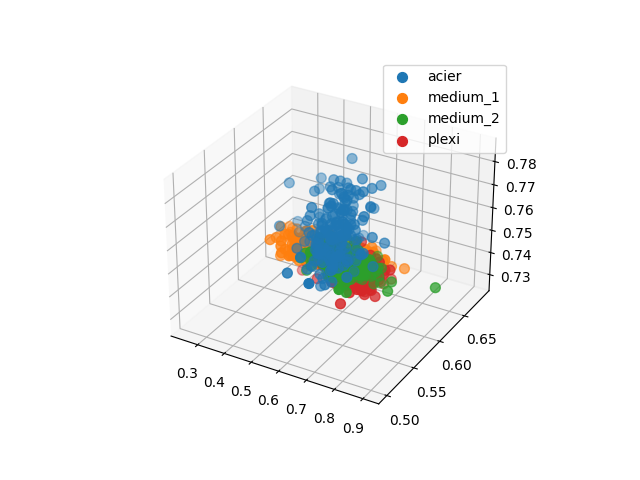

In [33]:
fig = plt.figure()
ax = plt.axes(projection='3d')
for cle in dict_class.keys():
    x_axis = dict_class[cle]['spectral_contrast_mean']
    y_axis = dict_class[cle]['spectral_flatness_mean']
    z_data = dict_class[cle]['spectral_bandwidth_mean']
    ax.scatter3D(x_axis,y_axis,z_data,marker ='o', s=50, label=cle[28:-1])
    ax.legend()

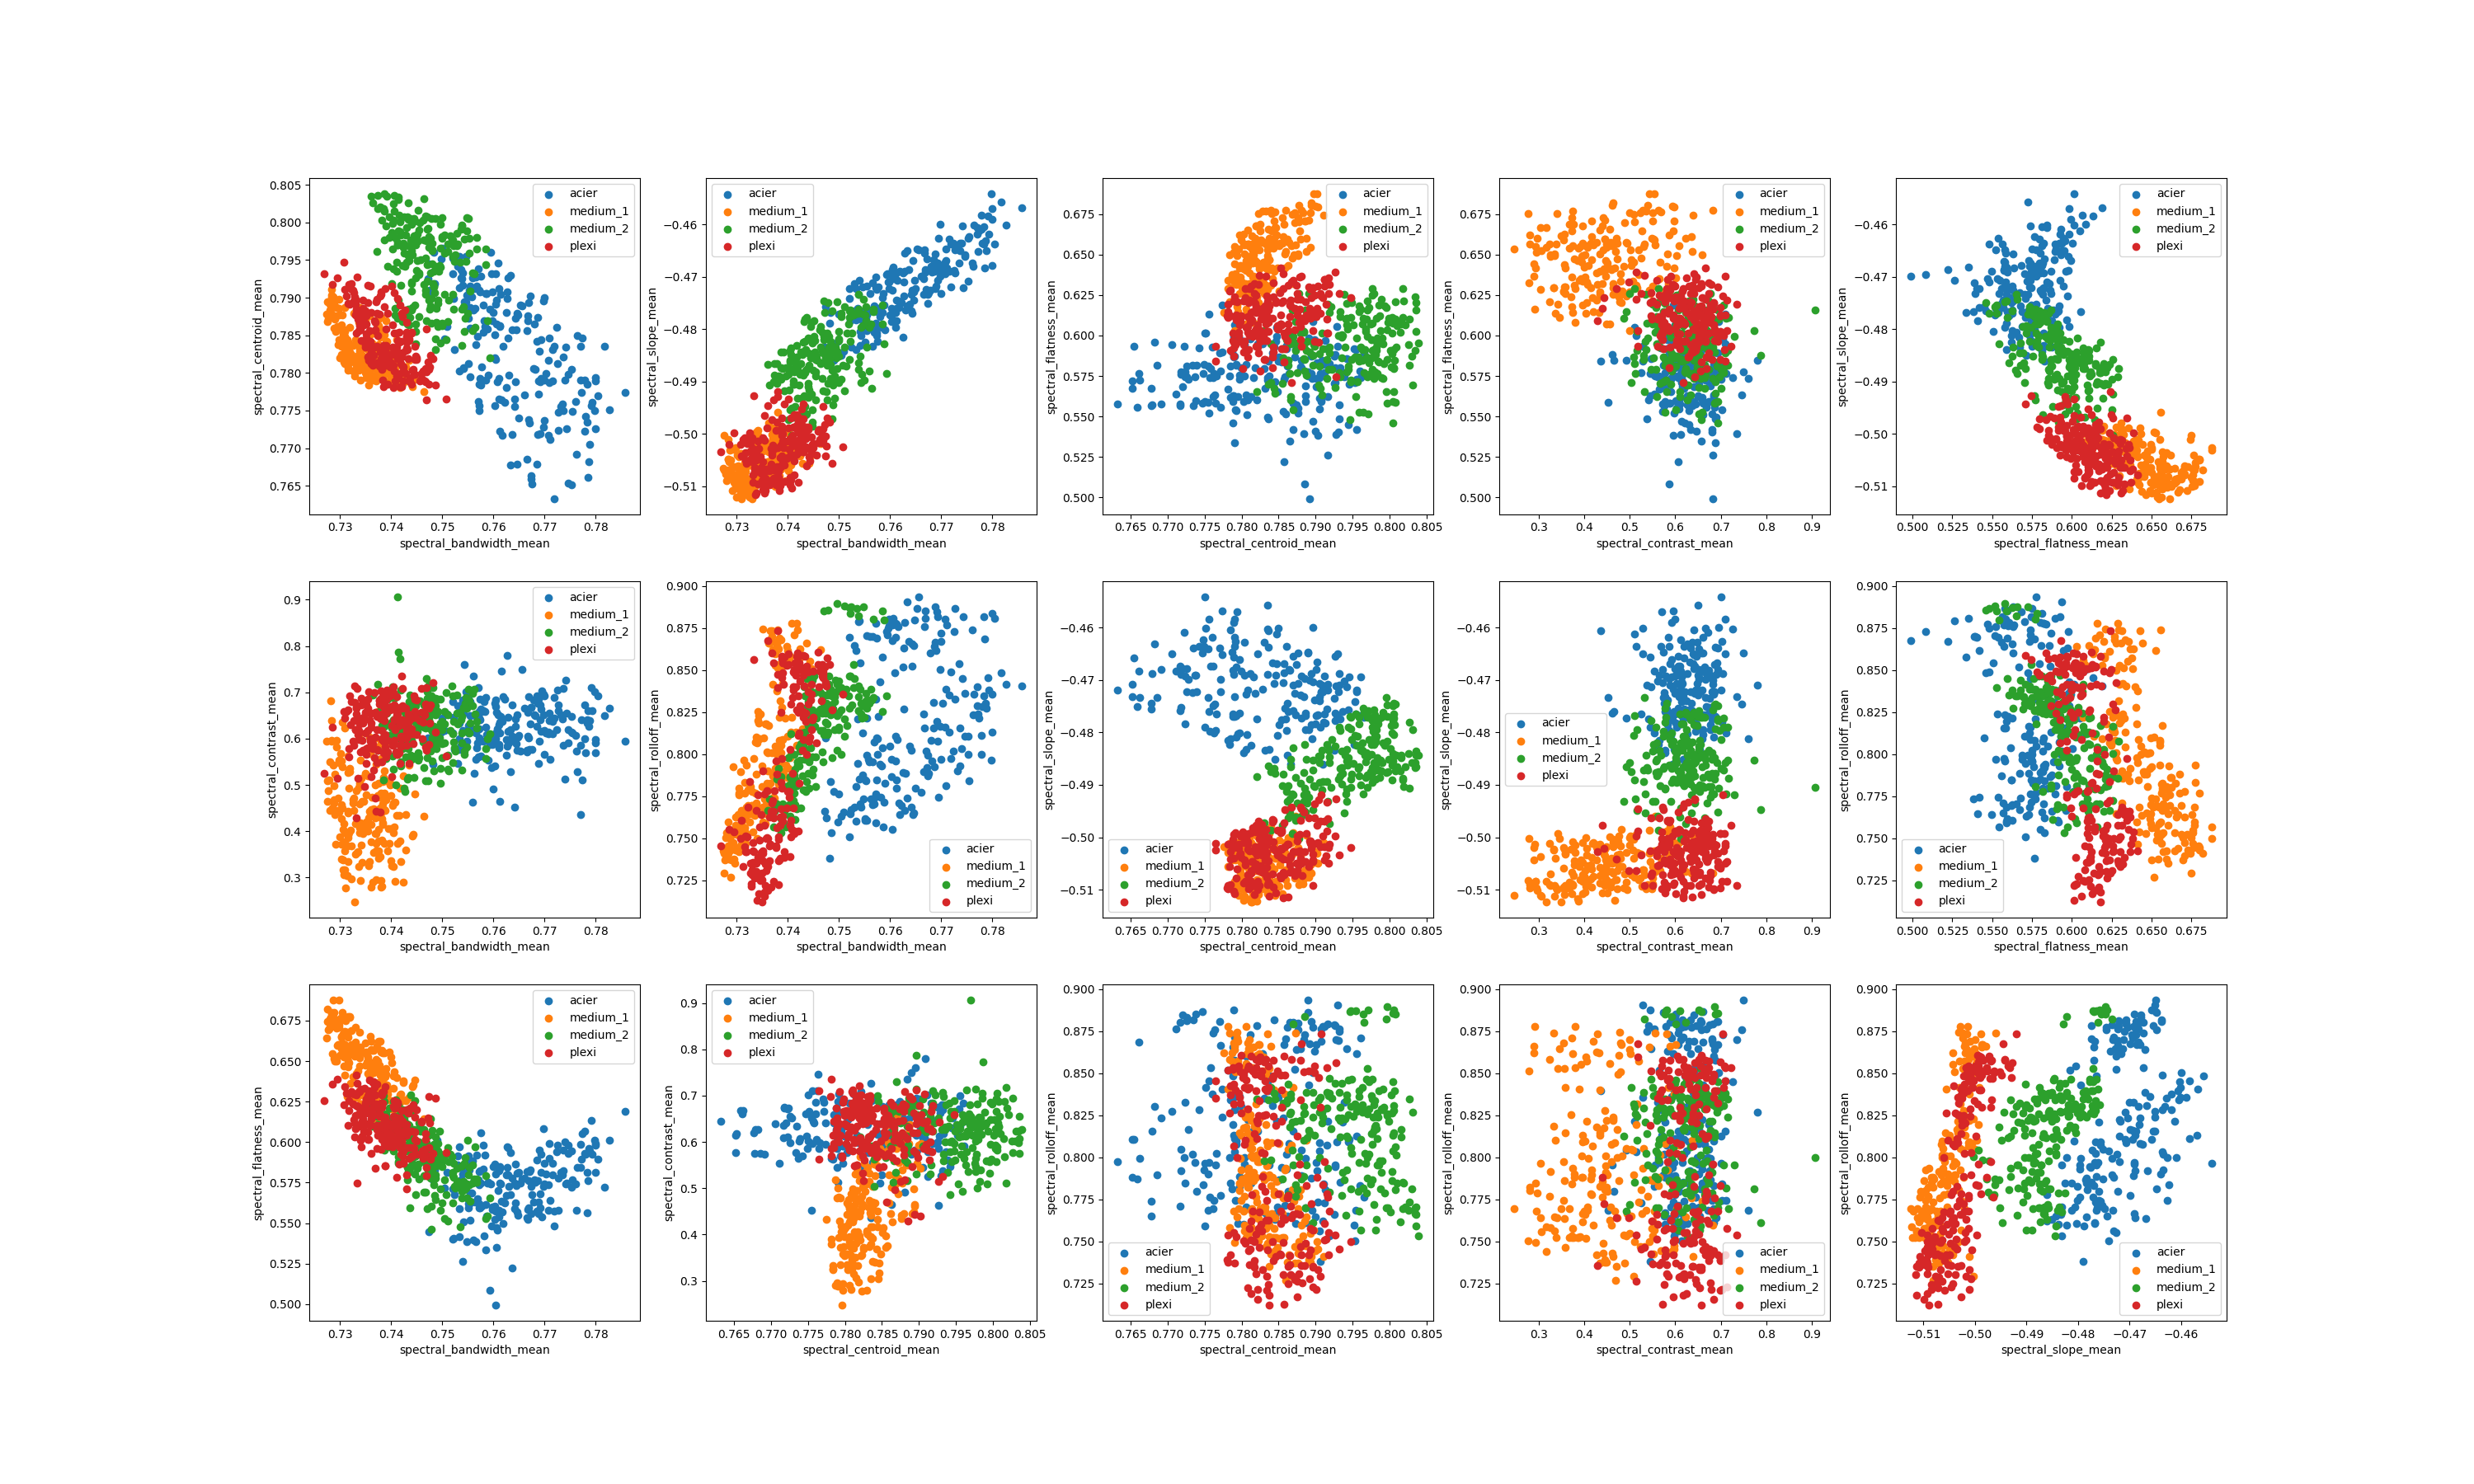

In [10]:
fig, ax = plt.subplots(3,5, figsize=(30,int(30*(3/5))))
i=0
j=0
for combinaison in liste_comb:
    for cle in dict_class.keys():
        x_axis = dict_class[cle][combinaison[0]]
        y_axis = dict_class[cle][combinaison[1]]
        ax[i,j].scatter(x_axis,y_axis,label=cle[28:-1])
        ax[i,j].set_xlabel(combinaison[0])
        ax[i,j].set_ylabel(combinaison[1])
        ax[i,j].legend()
    i+=1
    if i%3==0:
        j+=1
        i=0

# Comparaison entre synthèse et expérience

In [11]:
monRepertoire_experience = '../../Mesures/Mesures_2023.01.27_LAM_normalise/'
fichiers_table = [f for f in listdir(monRepertoire_experience) if not isfile(join(monRepertoire_experience, f))]
data_experience = {}
for matiere in fichiers_table:
    fichiers_corde = [f for f in listdir(monRepertoire_experience+matiere) if not isfile(join(monRepertoire_experience+matiere, f))]
    for corde in fichiers_corde:
        fichiers_mat = [f for f in listdir(monRepertoire_experience+matiere+'/'+corde) if (isfile(join(monRepertoire_experience+matiere+'/'+corde, f) ))]
        for mat in fichiers_mat:
            if mat != ".DS_Store":
                sig = scipy.io.loadmat(monRepertoire_experience+matiere+'/'+corde+'/'+mat)['acc_t']
                fs = scipy.io.loadmat(monRepertoire_experience+matiere+'/'+corde+'/'+mat)['fs'][0][0]
                time, wav = remove_init_noise(sig, fs, method="mean", ratio_parameter = 6, len_noise = 10000)
                wav = wav[:int(fs*3)]
                data_experience[matiere+'_'+corde+'_'+mat] = {}
                data_experience[matiere+'_'+corde+'_'+mat]['data'] = wav
                data_experience[matiere+'_'+corde+'_'+mat]['table_matiere'] = matiere
                data_experience[matiere+'_'+corde+'_'+mat]['corde_matiere'] = corde
                data_experience[matiere+'_'+corde+'_'+mat]['corde_plectre'] = mat
                data_experience[matiere+'_'+corde+'_'+mat]['Fe'] = fs
                
                if matiere == 'Metal':
                    data_experience[matiere+'_'+corde+'_'+mat]['rho_table'] = 2700
                if matiere == 'Plexi':
                    data_experience[matiere+'_'+corde+'_'+mat]['rho_table'] = 1180
                if matiere == 'Medium_1':
                    data_experience[matiere+'_'+corde+'_'+mat]['rho_table'] = 600
                if matiere == 'Medium_2':
                    data_experience[matiere+'_'+corde+'_'+mat]['rho_table'] = 800
                
                if 'C_1' in mat:
                    data_experience[matiere+'_'+corde+'_'+mat]['corde_numero'] = 1
                if 'C_2' in mat:
                    data_experience[matiere+'_'+corde+'_'+mat]['corde_numero'] = 2
                if 'C_3' in mat:
                    data_experience[matiere+'_'+corde+'_'+mat]['corde_numero'] = 3
                if 'C_4' in mat:
                    data_experience[matiere+'_'+corde+'_'+mat]['corde_numero'] = 4
                if 'C_5' in mat:
                    data_experience[matiere+'_'+corde+'_'+mat]['corde_numero'] = 5
                if 'C_6' in mat:
                    data_experience[matiere+'_'+corde+'_'+mat]['corde_numero'] = 6
                    
                if 'P_1' in mat:
                    data_experience[matiere+'_'+corde+'_'+mat]['plectre_numero'] = 1
                if 'P_2' in mat:
                    data_experience[matiere+'_'+corde+'_'+mat]['plectre_numero'] = 2
                if 'P_3' in mat:
                    data_experience[matiere+'_'+corde+'_'+mat]['plectre_numero'] = 3
                if 'P_4' in mat:
                    data_experience[matiere+'_'+corde+'_'+mat]['plectre_numero'] = 4

c:\users\ulysse\appdata\local\programs\python\python39\lib\site-packages\scipy\io\matlab\mio.py:224: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


In [18]:
all_cle_exp = list(data_experience.keys())
x_exp = data_experience[all_cle_exp[0]]['data']
Fe_exp = data_experience[all_cle_exp[0]]['Fe']

In [19]:
M_exp = np.zeros((len(x_exp), len(data_experience.keys())))
x_axis_exp = np.zeros(len(data_experience.keys()))
corde_numero_exp = np.zeros(len(data_experience.keys()))
i=0
for cle in all_cle_exp:
    M_exp[:,i] = np.reshape(data_experience[cle]['data'][:len(x_exp)],(len(x_exp)))
    corde_numero_exp[i] = data_experience[cle]['corde_numero']
    i+=1


In [20]:
data_features_exp={}
for k in range(len(data_experience.keys())):
    data_features_exp[all_cle_exp[k]] = compute_features(M_exp[:,k], sr=Fe_exp, S=None, n_fft=2048, hop_length=256, win_length=None, window='hann',
                     center=True, pad_mode='constant', freq=None, fmin=200.0, n_bands=6, quantile=0.02, linear=False, centroid=None, norm=True,
                     p=2, amin=1e-10, power=2.0,roll_percent=0.85)

In [21]:
l_exp = Fe_exp*3/256 #256 c'est pour hop_length, 3 la durée en seconde
debut_exp = int(l_exp//4) #Séparation entre l'attaque et le reste
fin_exp = -10

In [22]:

M_spec_bw_exp = np.zeros((len(data_features_exp[all_cle_exp[0]]['spectral_bandwidth'][0]),len(data_experience.keys())))
M_cent_exp = np.zeros((len(data_features_exp[all_cle_exp[0]]['spectral_centroid'][0]),len(data_experience.keys())))
M_contrast_exp = np.zeros((len(data_features_exp[all_cle_exp[0]]['spectral_contrast'][0]),len(data_experience.keys())))
M_flatness_exp = np.zeros((len(data_features_exp[all_cle_exp[0]]['spectral_flatness'][0]),len(data_experience.keys())))
M_slope_exp = np.zeros((len(data_features_exp[all_cle_exp[0]]['spectral_slope'][0]),len(data_experience.keys())))
M_rolloff_exp = np.zeros((len(data_features_exp[all_cle_exp[0]]['spectral_rolloff'][0]),len(data_experience.keys())))
i=0
for cle in all_cle_exp:
    M_spec_bw_exp[:,i] = data_features_exp[cle]['spectral_bandwidth'][0]
    M_cent_exp[:,i] = data_features_exp[cle]['spectral_centroid'][0]
    M_contrast_exp[:,i] = data_features_exp[cle]['spectral_contrast'][0]
    M_flatness_exp[:,i] = data_features_exp[cle]['spectral_flatness'][0]
    M_slope_exp[:,i] = data_features_exp[cle]['spectral_slope'][0]
    M_rolloff_exp[:,i] = data_features_exp[cle]['spectral_rolloff'][0]
    i+=1
M_spec_bw_mean_exp = np.mean(M_spec_bw_exp[debut_exp:fin_exp,:] /np.amax(np.abs(M_spec_bw_exp[debut_exp:fin_exp,:]), axis=0), axis=0)
M_cent_mean_exp = np.mean(M_cent_exp[debut_exp:fin_exp,:] /np.amax(np.abs(M_cent_exp[debut_exp:fin_exp,:]), axis=0), axis=0)
M_contrast_mean_exp = np.mean(M_contrast_exp[debut_exp:fin_exp,:] /np.amax(np.abs(M_contrast_exp[debut_exp:fin_exp,:]), axis=0), axis=0)
M_flatness_mean_exp = np.mean(M_flatness_exp[debut_exp:fin_exp,:] /np.amax(np.abs(M_flatness_exp[debut_exp:fin_exp,:]), axis=0), axis=0)
M_slope_mean_exp = np.mean(M_slope_exp[debut_exp:fin_exp,:] /np.amax(np.abs(M_slope_exp[debut_exp:fin_exp,:]), axis=0), axis=0)
M_rolloff_mean_exp = np.mean(M_rolloff_exp[debut_exp:fin_exp,:] /np.amax(np.abs(M_rolloff_exp[debut_exp:fin_exp,:]), axis=0), axis=0)
dict_class_exp = {}


k=0
for cle in all_cle_exp:
    dict_class_exp[cle] = {}
    dict_class_exp[cle]['spectral_bandwidth_mean'] = M_spec_bw_mean_exp[k]
    dict_class_exp[cle]['spectral_centroid_mean'] = M_cent_mean_exp[k]
    dict_class_exp[cle]['spectral_contrast_mean'] = M_contrast_mean_exp[k]
    dict_class_exp[cle]['spectral_flatness_mean'] = M_flatness_mean_exp[k]
    dict_class_exp[cle]['spectral_slope_mean'] = M_slope_mean_exp[k]
    dict_class_exp[cle]['spectral_rolloff_mean'] = M_rolloff_mean_exp[k]
    k+=1

# Plot des features moyennes pour les expériences

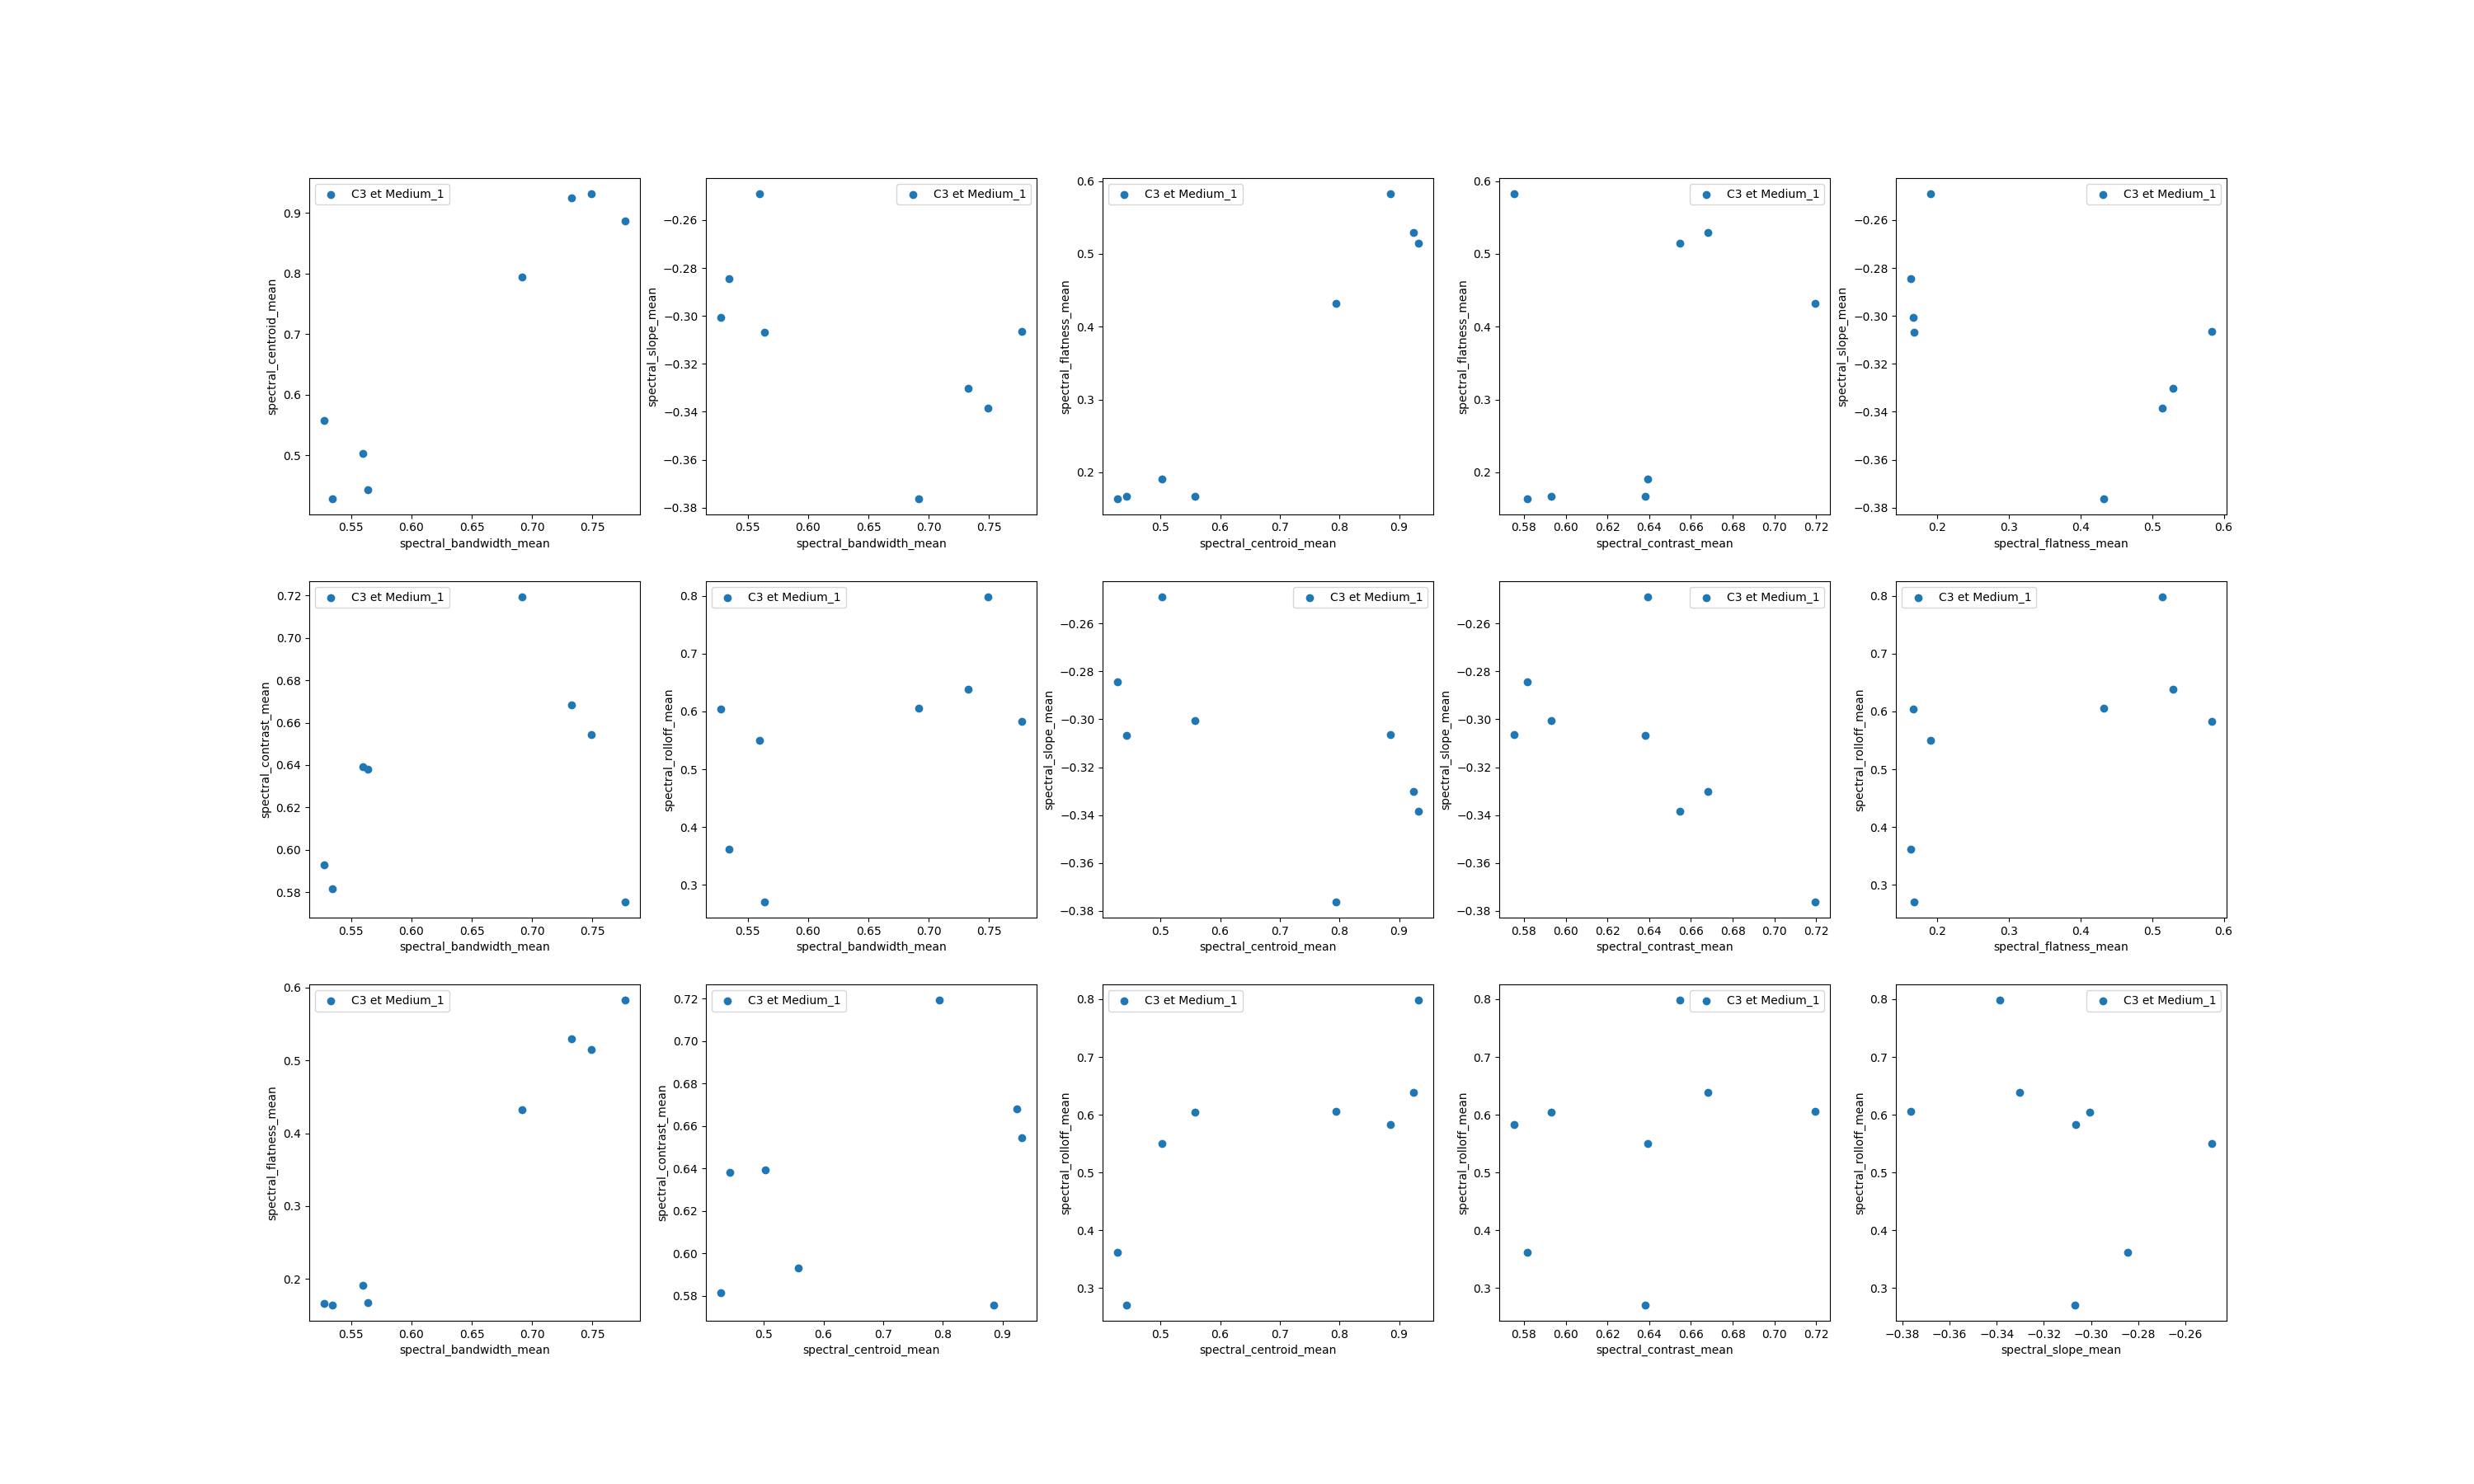

In [28]:
fig, ax = plt.subplots(3,5, figsize=(30,int(30*(3/5))))
i=0
j=0
for combinaison in liste_comb:
    x_axis = []
    y_axis = []
    for cle in all_cle_exp:
        
        if 'C_3' in cle and 'Medium_1' in cle: # Il faut bien choisir quelles données d'expériences on veut visualiser
            x_axis.append(dict_class_exp[cle][combinaison[0]])
            y_axis.append(dict_class_exp[cle][combinaison[1]])
    ax[i,j].scatter(x_axis,y_axis,label='C3 et Medium_1')
    ax[i,j].set_xlabel(combinaison[0])
    ax[i,j].set_ylabel(combinaison[1])
    ax[i,j].legend()
    i+=1
    if i%3==0:
        j+=1
        i=0
    

# Comparaison entre les features moyennes de la synthèse et de l'expérience

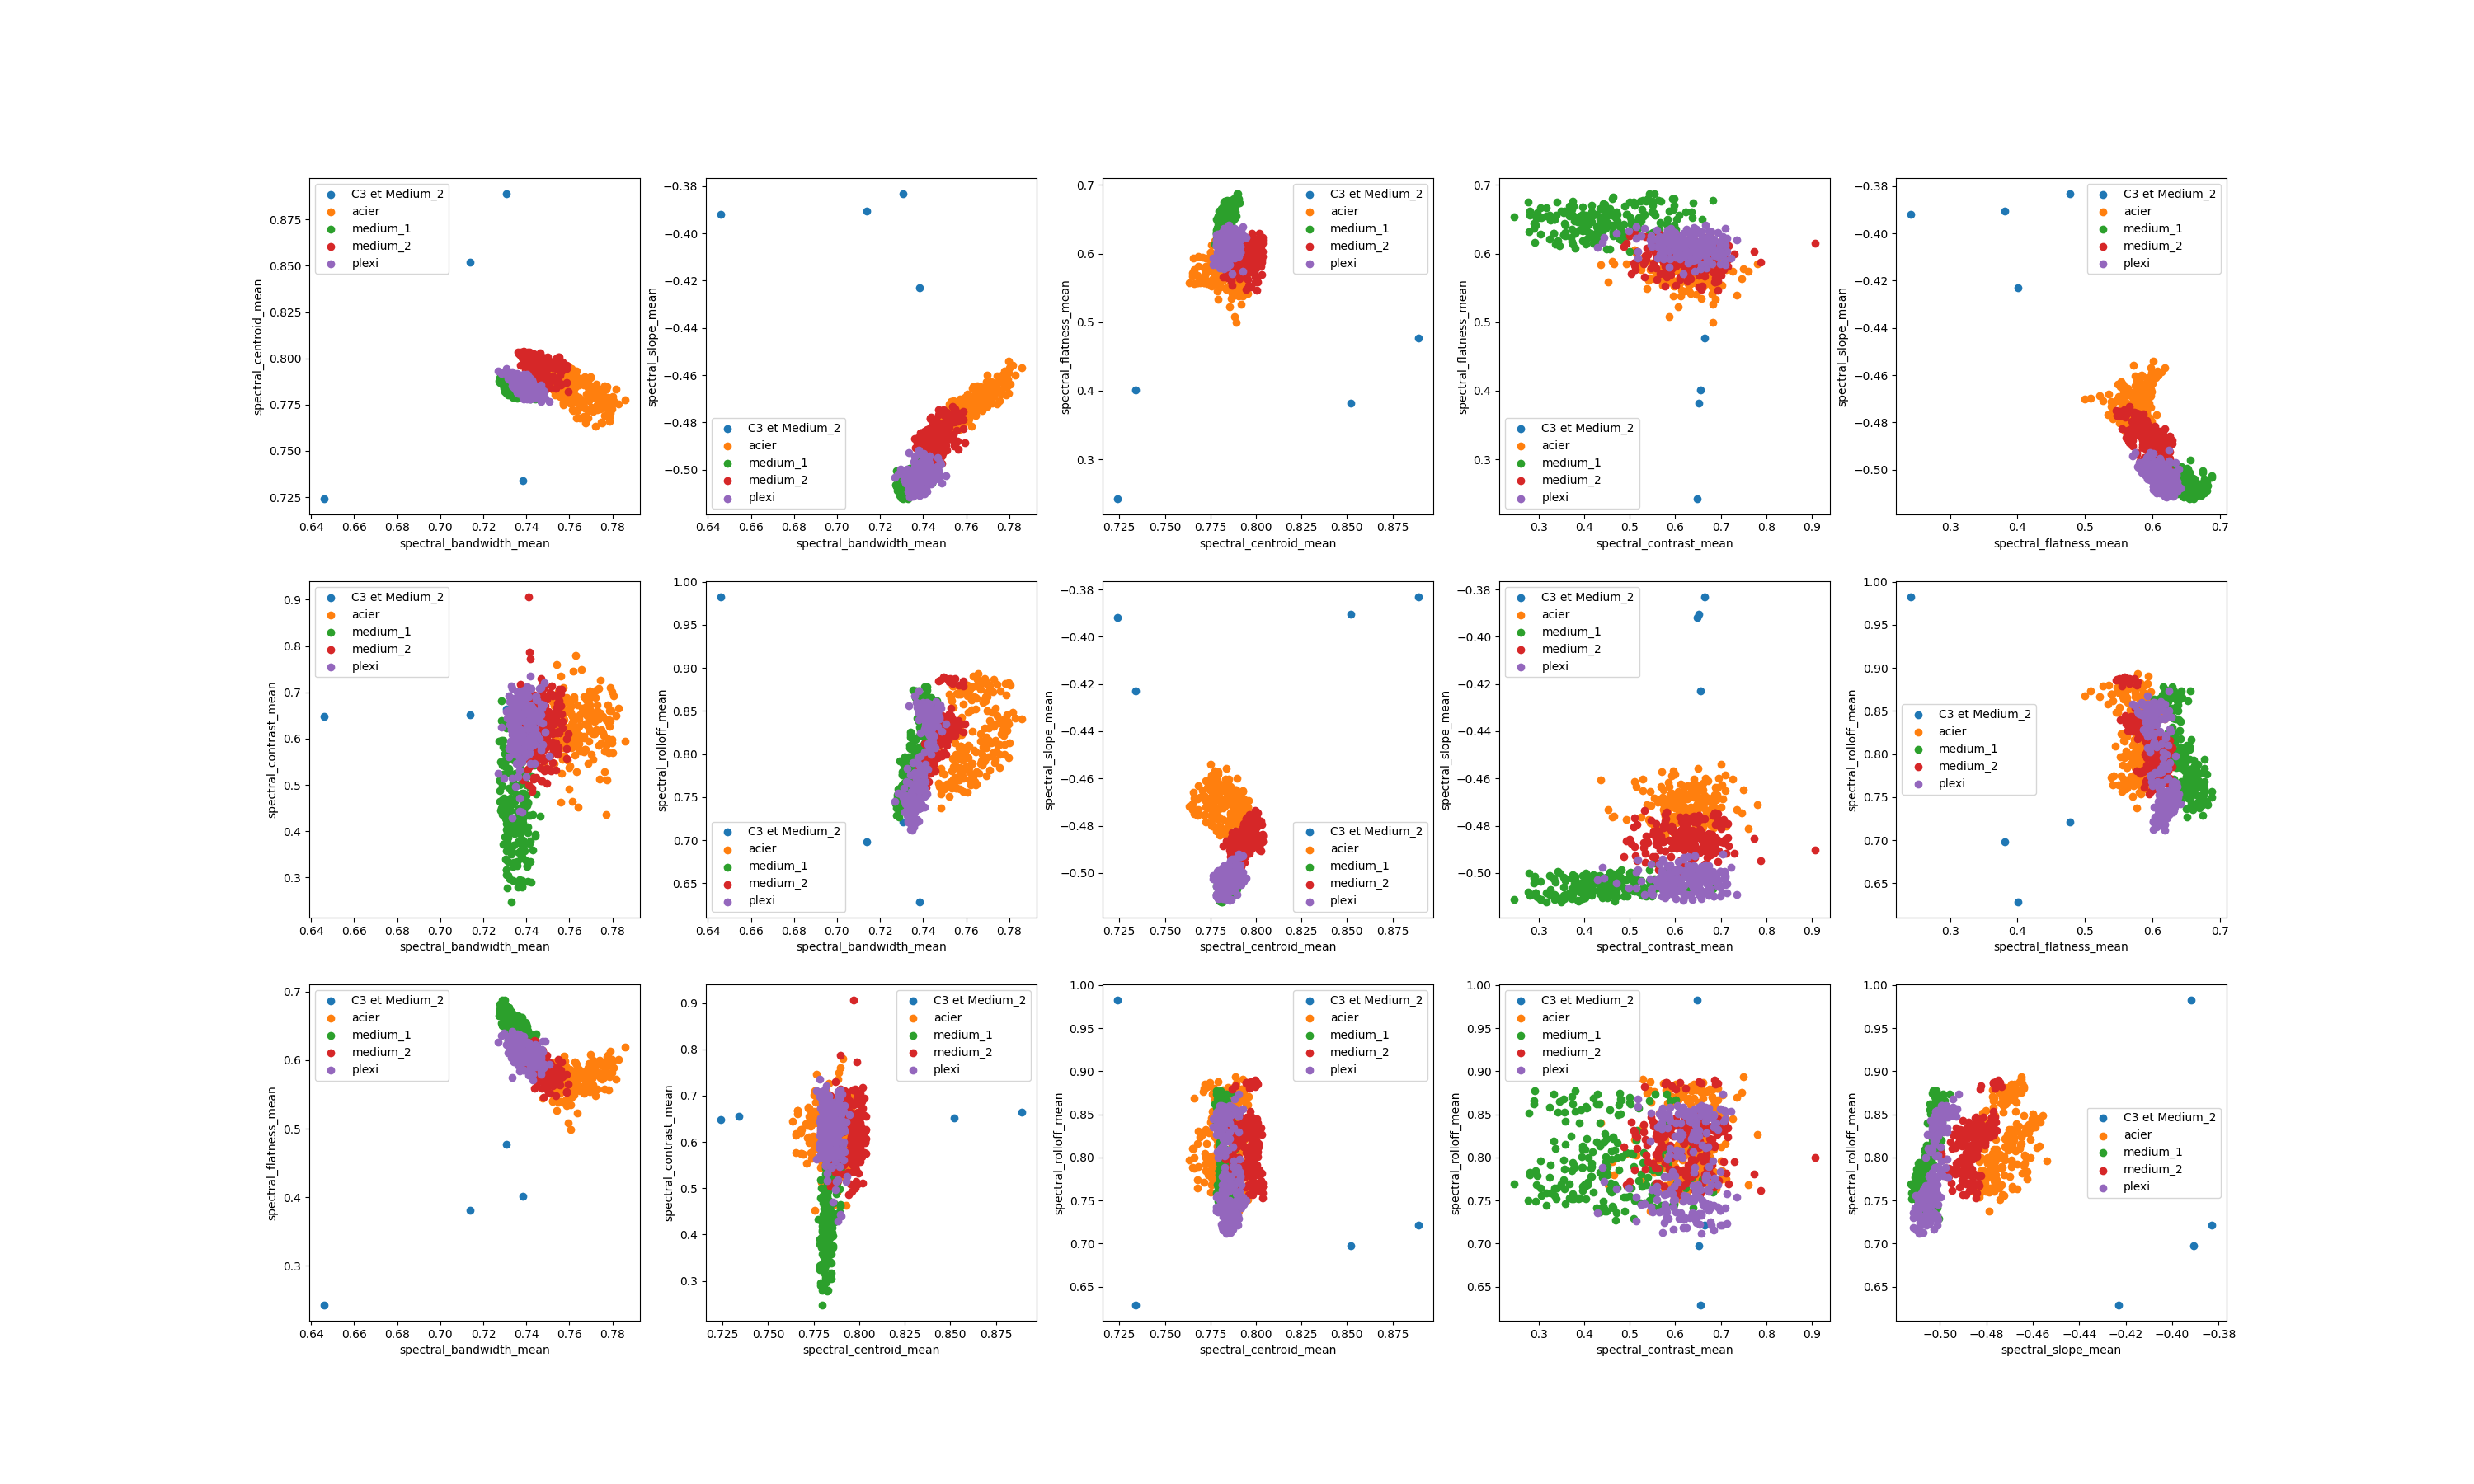

In [25]:
fig, ax = plt.subplots(3,5, figsize=(30,int(30*(3/5))))
i=0
j=0
for combinaison in liste_comb:
    k=0
    x_axis = []
    y_axis = []
    for cle in all_cle_exp:
        
        if 'C_3' in cle and 'Medium_2' in cle: # Il faut bien choisir quelles données d'expériences on veut visualiser
            x_axis.append(dict_class_exp[cle][combinaison[0]])
            y_axis.append(dict_class_exp[cle][combinaison[1]])
    ax[i,j].scatter(x_axis,y_axis,label='C3 et Medium_2')
    ax[i,j].set_xlabel(combinaison[0])
    ax[i,j].set_ylabel(combinaison[1])
    ax[i,j].legend()
    for cle in dict_class.keys():
        x_axis = dict_class[cle][combinaison[0]]
        y_axis = dict_class[cle][combinaison[1]]
        ax[i,j].scatter(x_axis,y_axis,label=cle[28:-1])
        ax[i,j].set_xlabel(combinaison[0])
        ax[i,j].set_ylabel(combinaison[1])
        ax[i,j].legend()
    i+=1
    if i%3==0:
        j+=1
        i=0
        